In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
import binarytree as bt

In [2]:
def setup_dataframes():
    df = pd.read_csv('MM_game_data.csv')
    df = df[df['YEAR'] >= 2013]
    df = df[df['YEAR'] <= 2023]
    np.unique(df['YEAR'])
    games = df.drop(['ROUND'], axis=1)
    
    df = pd.read_csv('cbb.csv')
    df = df[df['SEED'] > 0]
    df = df[df['YEAR'] <= 2023]
    teams = df.drop(['CONF', 'POSTSEASON', 'SEED'], axis=1)
    
    rv = np.floor(np.random.rand(len(games))*2)
    
    return (games,teams,rv)

In [3]:
def get_team_data(team, year):
    all_years = teams.loc[teams['TEAM'] == team]
    specific_year = all_years.loc[all_years['YEAR'] == year]
    return specific_year

In [4]:
def assemble_game_data():
    game_data = np.zeros(shape=(len(games), 38))
    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        if rv[i] == 0:
            game_data[i] = np.hstack([wdata, ldata])
        else:
            game_data[i] = np.hstack([ldata, wdata])
    return game_data

In [5]:
def assemble_response_data():
    score_diff = []
    for i in range(0,len(games)):
        if rv[i] == 0:
            score_diff.append(games.iloc[i]['WSCORE'] - games.iloc[i]['LSCORE'])
        else:
            score_diff.append(games.iloc[i]['LSCORE'] - games.iloc[i]['WSCORE'])
    return score_diff

In [6]:
def get_invalid_team_names():
    wrong_names = []

    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR'])
        if wdata.empty:
            wrong_names.append(games.iloc[i]['WTEAM'])
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR'])
        if ldata.empty:
            wrong_names.append(games.iloc[i]['LTEAM'])
    return np.unique(wrong_names)

In [7]:
def process_bracket(model):
    numlist = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
    df = pd.read_csv('2023bracket.csv')
    
    FF = first_four_winners(df, model) 
    print("First four winners: " + str(FF))
    south = [None] * 16
    east = [None] * 16
    midwest = [None] * 16
    west = [None] * 16
    
    for i in range(16):
        if i == 15:
            south[numlist.index(i+1)] = FF[0]
            east[numlist.index(i+1)] = FF[1]
        else:
            southdata = df.loc[(df['Division'] == 'South') & (df['Seed'] == str(i+1))]
            south[numlist.index(i+1)] = str(southdata.iloc[0]['Team'])
            eastdata = df.loc[(df['Division'] == 'East') & (df['Seed'] == str(i+1))]
            east[numlist.index(i+1)] = str(eastdata.iloc[0]['Team'])
        if i == 10:
            midwest[numlist.index(i+1)] = FF[2]
            west[numlist.index(i+1)] = FF[3]
        else:
            midwestdata = df.loc[(df['Division'] == 'Midwest') & (df['Seed'] == str(i+1))]
            midwest[numlist.index(i+1)] = str(midwestdata.iloc[0]['Team'])
            westdata = df.loc[(df['Division'] == 'West') & (df['Seed'] == str(i+1))]
            west[numlist.index(i+1)] = str(westdata.iloc[0]['Team'])
            
    south1 = []
    east1 = []
    midwest1 = []
    west1 = []
    for i in range(int(len(south)/2)):
        south1.append(pred_winner(south[2*i], south[2*i+1]))
        east1.append(pred_winner(east[2*i], east[2*i+1]))
        midwest1.append(pred_winner(midwest[2*i], midwest[2*i+1]))
        west1.append(pred_winner(west[2*i], west[2*i+1]))
    
    print("Round 1 winners: ")
    print(south1)
    print(east1)
    print(midwest1)
    print(west1)
    
    south2 = []
    east2 = []
    midwest2 = []
    west2 = []
    for i in range(int(len(south1)/2)):
        south2.append(pred_winner(south1[2*i], south1[2*i+1]))
        east2.append(pred_winner(east1[2*i], east1[2*i+1]))
        midwest2.append(pred_winner(midwest1[2*i], midwest1[2*i+1]))
        west2.append(pred_winner(west1[2*i], west1[2*i+1]))
    
    print("Round 2 winners: ")
    print(south2)
    print(east2)
    print(midwest2)
    print(west2)
    
    south3 = []
    east3 = []
    midwest3 = []
    west3 = []
    for i in range(int(len(south2)/2)):
        south3.append(pred_winner(south2[2*i], south2[2*i+1]))
        east3.append(pred_winner(east2[2*i], east2[2*i+1]))
        midwest3.append(pred_winner(midwest2[2*i], midwest2[2*i+1]))
        west3.append(pred_winner(west2[2*i], west2[2*i+1]))
    
    print("Sweet 16 winners: ")
    print(south3)
    print(east3)
    print(midwest3)
    print(west3)
    
    final4 = []
    for i in range(int(len(south3)/2)):
        final4.append(pred_winner(south3[2*i], south3[2*i+1]))
        final4.append(pred_winner(east3[2*i], east3[2*i+1]))
        final4.append(pred_winner(midwest3[2*i], midwest3[2*i+1]))
        final4.append(pred_winner(west3[2*i], west3[2*i+1]))
    
    print("Elite 8 winners: ")
    print(final4)
    
    final2 = []
    for i in range(int(len(final4)/2)):
        final2.append(pred_winner(final4[2*i], final4[2*i+1]))
    
    print("Final 4 winners: ")
    print(final2)
    
    print("Champion:")
    print(pred_winner(final2[0], final2[1]))
    
    return        
    

In [8]:
def first_four_winners(df, model):
    FF = []
    for index, row in df[df['Seed'] == 'FF'].iterrows():
        FF.append(row['Team'])
    
    FFwinners = []
    for i in range(int(len(FF)/2)):
        winner = pred_winner(FF[2*i], FF[2*i+1])
        FFwinners.append(winner)
    
    return FFwinners

In [9]:
def pred_winner(name1, name2):
    team1 = get_team_data(name1, 2023).drop(['TEAM', 'YEAR'], axis=1)
    if (team1.empty):
        print(name1)
    team2 = get_team_data(name2, 2023).drop(['TEAM', 'YEAR'], axis=1)
    if (team2.empty):
        print(name2)
    data = np.hstack([team1, team2])
    prob = model(data)[:,1]
    if prob > 0.5:
        return name1
    else:
        return name2

In [65]:
def create_game_bracket():
    games = ["Finale", "FF1", "FF2", "EES", "EEE", "EEM", "EEW", "SSS1", "SSS2", "SSE1", "SSE2", "SSM1", "SSM2", "SSW1", "SSW2",
            "R2S1", "R2S2", "R2S3", "R2S4", "R2E1", "R2E2", "R2E3", "R2E4", "R2M1", "R2M2", "R2M3", "R2M4", "R2W1", "R2W2", 
            "R2W3", "R2W4", "R1S1", "R1S2", "R1S3", "R1S4", "R1S5", "R1S6", "R1S7", "R1S8", "R1E1", "R1E2", "R1E3", "R1E4", 
            "R1E5", "R1E6", "R1E7", "R1E8", "R1M1", "R1M2", "R1M3", "R1M4", "R1M5", "R1M6", "R1M7", "R1M8", "R1W1", "R1W2", 
            "R1W3", "R1W4", "R1W5", "R1W6", "R1W7", "R1W8", None, "FFS", None, None, None, None, None, None, None, None, None,
            None, None, None, None, None, None, "FFE", None, None, None, None, None, None, None, None, None, None, None, None, 
            None, None, None, None, None, None, None, None, None, None, None, "FFM", None, None, None, None, None, None, None,
            None, None, None, None, None, None, None, None,"FFW"]
    
    tree = bt.build(games)
    return tree

In [67]:
def process_bracket_tree(node, model):
    numlist = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
    df = pd.read_csv('2023bracket.csv')
    
    if (node.left == None) and (node.right == None):
        if node.value[:2] == "FF":
            print("First four")
        else:
            division = node.value[2]
            gameno = node.value[3]
            print(division, gameno)
    elif (node.left == None):
        t1 = process_bracket_tree(node.right, model)
    else:
        t1 = process_bracket_tree(node.left, model)
        t2 = process_bracket_tree(node.right, model)

In [68]:
root = create_game_bracket()
process_bracket_tree(root, 1)

First four
S 2
S 3
S 4
S 5
S 6
S 7
S 8
First four
E 2
E 3
E 4
E 5
E 6
E 7
E 8
M 1
M 2
M 3
M 4
First four
M 6
M 7
M 8
W 1
W 2
W 3
W 4
First four
W 6
W 7
W 8


In [10]:
(games,teams,rv) = setup_dataframes()

In [11]:
game_data = assemble_game_data()
score_data = assemble_response_data()
X_train, X_test, y_train, y_test = train_test_split(game_data, score_data, test_size=0.2, random_state=1)

0.4465408386566766

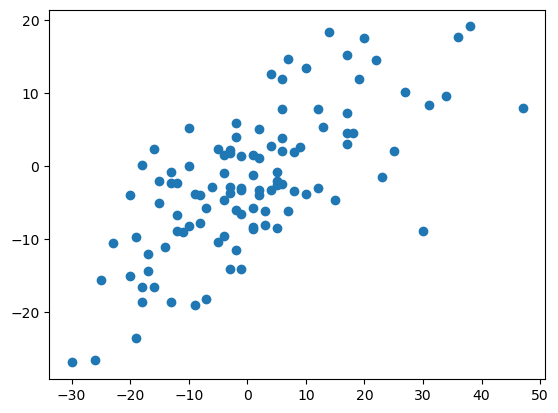

In [12]:
regr = MLPRegressor(random_state=1).fit(X_train, y_train)

pred = regr.predict(X_test)
plt.scatter(y_test, pred)
regr.score(X_test, y_test)

In [13]:
win_data = (np.sign(score_data) + 1)/2

In [14]:
layers = [tf.keras.Input(shape=(None,38)), Dense(1000, activation="relu"), Dropout(0.1), Dense(500, activation="relu"), Dropout(0.2), Dense(250, activation="relu"), Dense(2, activation="softmax")]
model = tf.keras.models.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 1000)        39000     
                                                                 
 dropout (Dropout)           (None, None, 1000)        0         
                                                                 
 dense_1 (Dense)             (None, None, 500)         500500    
                                                                 
 dropout_1 (Dropout)         (None, None, 500)         0         
                                                                 
 dense_2 (Dense)             (None, None, 250)         125250    
                                                                 
 dense_3 (Dense)             (None, None, 2)           502       
                                                                 
Total params: 665252 (2.54 MB)
Trainable params: 665252 

In [15]:
n_epochs = 50
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(game_data, win_data, epochs=n_epochs)

Epoch 1/50
17/17 [==============================] - 4s 23ms/step - loss: 8.3998 - accuracy: 0.5327
Epoch 2/50
17/17 [==============================] - 0s 22ms/step - loss: 1.5093 - accuracy: 0.4953
Epoch 3/50
17/17 [==============================] - 0s 21ms/step - loss: 0.8388 - accuracy: 0.5458
Epoch 4/50
17/17 [==============================] - 0s 21ms/step - loss: 0.7065 - accuracy: 0.5813
Epoch 5/50
17/17 [==============================] - 0s 22ms/step - loss: 0.7852 - accuracy: 0.5215
Epoch 6/50
17/17 [==============================] - 0s 21ms/step - loss: 0.6875 - accuracy: 0.6206
Epoch 7/50
17/17 [==============================] - 0s 20ms/step - loss: 0.6857 - accuracy: 0.6037
Epoch 8/50
17/17 [==============================] - 0s 21ms/step - loss: 0.6146 - accuracy: 0.6579
Epoch 9/50
17/17 [==============================] - 0s 21ms/step - loss: 0.6130 - accuracy: 0.6879
Epoch 10/50
17/17 [==============================] - 0s 21ms/step - loss: 0.6667 - accuracy: 0.6411
Epoch 11/

In [16]:
pred = model(game_data)
confusion_matrix(win_data, np.round(pred[:,1]))

array([[200,  79],
       [ 33, 223]], dtype=int64)

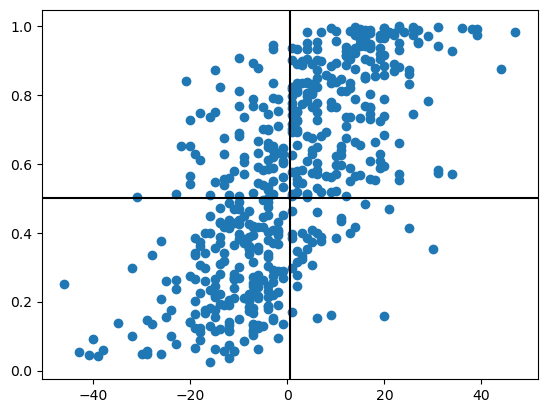

In [24]:
plt.scatter(score_data, pred[:,1])
plt.axhline(0.5, c="black")
plt.axvline(0.5, c="black")

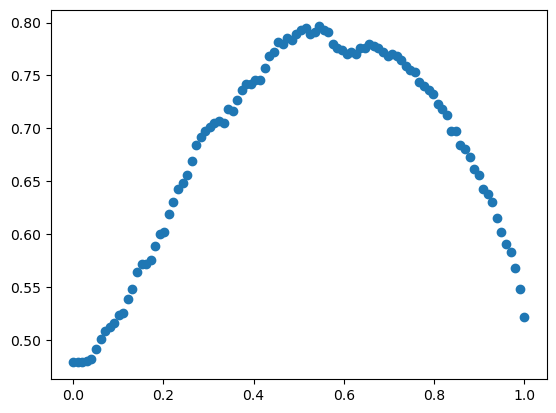

In [18]:
cutoffs = np.linspace(0, 1, 100)
accuracies = []
for cutoff in cutoffs:
    pred1 = np.ceil(pred[:,1] - cutoff)
    accuracies.append(accuracy_score(win_data, pred1))
    
plt.scatter(cutoffs, accuracies)

In [19]:
process_bracket(model)

First four winners: ['Texas A&M Corpus Chris', 'Fairleigh Dickinson', 'Pittsburgh', 'Arizona St.']
Round 1 winners: 
['Alabama', 'Maryland', 'San Diego St.', 'Virginia', 'Creighton', 'Baylor', 'Missouri', 'Arizona']
['Purdue', 'Florida Atlantic', 'Duke', 'Tennessee', 'Kentucky', 'Kansas St.', 'Michigan St.', 'Marquette']
['Houston', 'Auburn', 'Miami FL', 'Indiana', 'Iowa St.', 'Xavier', 'Texas A&M', 'Texas']
['Kansas', 'Arkansas', "Saint Mary's", 'Connecticut', 'TCU', 'Gonzaga', 'Northwestern', 'UCLA']
Round 2 winners: 
['Alabama', 'San Diego St.', 'Baylor', 'Missouri']
['Florida Atlantic', 'Duke', 'Kansas St.', 'Marquette']
['Houston', 'Miami FL', 'Xavier', 'Texas']
['Kansas', 'Connecticut', 'Gonzaga', 'UCLA']
Sweet 16 winners: 
['Alabama', 'Baylor']
['Florida Atlantic', 'Marquette']
['Houston', 'Texas']
['Kansas', 'Gonzaga']
Elite 8 winners: 
['Alabama', 'Florida Atlantic', 'Houston', 'Kansas']
Final 4 winners: 
['Alabama', 'Houston']
Champion:
Houston
